http://docs.echonest.com.s3-website-us-east-1.amazonaws.com/_static/AnalyzeDocumentation.pdf
http://web.media.mit.edu/~tristan/phd/dissertation/index.html

In [1]:
import pandas as pd #Dataframe, Series
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns

import graphviz
import pydotplus
import io

from scipy import misc

from sklearn.metrics import accuracy_score

import spotipy
import spotipy.util as util
sp = spotipy.Spotify() 
from spotipy.oauth2 import SpotifyClientCredentials 

In [25]:
cid ="0cadd882a6ab4ff485c80b8b02aa3b0c" 
secret = "04d0f737e18a4a92abee1da25d70766b"
username = ""

client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

scope = 'user-library-read playlist-read-private user-read-recently-played user-read-playback-state user-modify-playback-state'
token = util.prompt_for_user_token(username, scope)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [3]:
data = []

analysis = sp.audio_analysis("3m9eTtBtU0xxJndQRz9MOr")
print(analysis["track"]["tempo"])

165.87


In [4]:
X = []
Y = []

for segment in analysis["segments"]:
    if(segment["start"] < 20):
        X.append(segment["pitches"])
        start = segment["start"]
        end = segment["start"] + segment["duration"]
        Y.append(start)

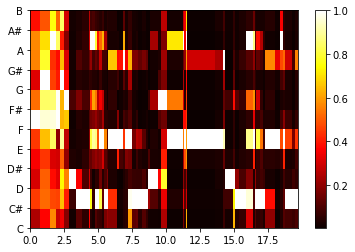

In [5]:
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib as mpl
from scipy.interpolate import interp2d

pitches = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

# Set figure width to 12 and height to 9
#fig_size[0] = 24
#fig_size[1] = 8
#plt.rcParams["figure.figsize"] = fig_size

cMap = mpl.cm.hot

plt.pcolormesh(Y, np.arange(12), np.transpose(X), cmap=cMap)
plt.colorbar()
plt.yticks( np.arange(12), pitches )
plt.show()

In [27]:
import networkx as nx
def euc_distance(s1, s2):
    return np.linalg.norm(s1-s2)

def weighted_euc_distance(s1,s2,w):
    q = s1-s2
    return np.sqrt((w*q*q).sum())
def calucate_distance(seg1, seg2):
    pitch_dist = euc_distance(np.array(seg1["pitches"]),np.array(seg2["pitches"]))
    timbre_dist = weighted_euc_distance(np.array(seg1["timbre"]), np.array(seg2["timbre"]),1)
    start_loudness_dist = abs(seg1["loudness_start"] - seg2["loudness_start"])
    max_loudness_dist = abs(seg1["loudness_max"] - seg2["loudness_max"])
    duration_dist = abs(seg1["duration"] - seg2["duration"])
    confidence_dist = abs(seg1["confidence"] - seg2["confidence"])
    distance = timbre_dist + pitch_dist * 10 + start_loudness_dist + max_loudness_dist + duration_dist * 100 + confidence_dist
    return distance
def get_top_four_closest_segments(segment_number):
    segment_distance = []
    for i in range(0, len(analysis["segments"])):
        if i != segment_number:
            distance = calucate_distance(analysis["segments"][segment_number], analysis["segments"][i])
            if(distance < 80 and distance != 0):
                segment_distance.append({"distance": distance, "number": i})
    return sorted(segment_distance, key=lambda x: x["distance"], reverse=False)[0:4]

def make_graph_from_close_segments():
    to = []
    fromArray = []
    for i in range(0, len(analysis["segments"])):
        closestSegments = get_top_four_closest_segments(i)
        for segment in closestSegments:
            to.append(segment["number"])
            fromArray.append(i)
    df = pd.DataFrame({ 'from':fromArray, 'to':to })
    G = nx.from_pandas_edgelist(df, "from", "to")
    return G

In [28]:
G = make_graph_from_close_segments()

In [31]:
import random
jumps = []
sourceVerticies = []
#print(Counter(fromEdges))
for u,v in G.edges:
    if random.random() < .1:
        if random.random() < .5:
            if u not in sourceVerticies:
                print(u, v)
                jumps.append({"from": u, "to": v})
                sourceVerticies.append(u)
            else:
                if v not in sourceVerticies:
                    print(v, u)
                    jumps.append({"from": v, "to": u})
                    sourceVerticies.append(v)
        else:
            if v not in sourceVerticies:
                print(v, u)
                jumps.append({"from": v, "to": u})
                sourceVerticies.append(v)
            else:
                if u not in sourceVerticies:
                    print(u, v)
                    jumps.append({"from": u, "to": v})
                    sourceVerticies.append(u)
    

573 13
25 49
34 601
569 62
159 74
321 83
319 83
87 230
98 144
104 230
110 418
117 242
124 226
125 128
330 125
126 321
160 345
353 166
365 173
178 399
230 185
188 273
195 391
324 195
198 205
429 201
210 231
215 237
273 221
347 221
374 236
466 237
238 467
240 510
419 243
278 247
260 250
307 273
579 276
280 281
312 310
318 390
343 324
332 487
413 333
341 337
339 486
397 341
346 487
349 383
497 352
394 353
486 355
414 361
531 366
373 466
381 374
477 375
378 455
385 431
432 386
442 393
427 396
400 406
405 421
456 407
502 414
416 430
470 457
459 458
479 522
499 480
509 485
485 543
521 492
493 531
533 493
539 494
516 497
536 497
542 497
520 505
594 550
570 600


In [ ]:
i=0
newlist = sorted(jumps, key=lambda k: k['from']) 
while i < len(jumps):
    player = sp._get("me/player")
    if player["progress_ms"] >= analysis["segments"][newlist[i]["from"]]["start"]*1000:
        jump_to = analysis["segments"][newlist[i]["to"]]["start"]*1000
        i=i+1
        sp._put("me/player/seek?position_ms="+str(int(round(jump_to))))

In [42]:
print(newlist[0])

{'to': 49, 'from': 25}


In [36]:
import time
print(analysis["segments"][25]["start"])
print(analysis["segments"][25]["duration"])

print(analysis["segments"][260]["start"])

sp._put("me/player/seek?position_ms=2500")
time.sleep(0.16317)
sp._put("me/player/seek?position_ms=26000")

7.82966
0.16317
76.70635
